### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# load the dataset
ames = pd.read_csv('housing.csv')
ames

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
# Check column names for renaming
ames.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
# Use the data_description.txt to give columns more appropriate names
new_columns_dict = {
    'Id':'ID', 
    'MSSubClass':'Class',
    'MSZoning':'Zoning',
    'LotFrontage':'Frontage Square Feet',
    'LotArea':'Total Square Feet',
    'Street':'Road Access',
    'Alley':'Alley Access',
    'LotShape':'Shape',
    'LandContour':'Flatness',
    'Utilities':'Utilities',
    'LotConfig':'Configuration',
    'LandSlope':'Slope',
    'Neighborhood':'Neighborhood',
    'Condition1':'Proximity to Conditions 1',
    'Condition2':'Proximity to Conditions 2',
    'BldgType':'Type',
    'HouseStyle':'Style',
    'OverallQual':'Quality',
    'OverallCond':'Condition',
    'YearBuilt':'Year Built',
    'YearRemodAdd':'Year Remodel',
    'RoofStyle':'Roof Style',
    'RoofMatl':'Roof Material',
    'Exterior1st':'Exterior Material',
    'Exterior2nd':'Exterior Material 2',
    'MasVnrType':'Masonry Veneer Type',
    'MasVnrArea':'Masonry Veneer Sq Ft',
    'ExterQual':'Exterior Quality',
    'ExterCond':'Exterior Condition',
    'Foundation':'Foundation',
    'BsmtQual':'Basement Height',
    'BsmtCond':'Basement Condition',
    'BsmtExposure':'Basement Exposure',
    'BsmtFinType1':'Basement Rating',
    'BsmtFinSF1':'Basement Finished Sq Ft',
    'BsmtFinType2':'Basement Rating 2',
    'BsmtFinSF2':'Basement Finished Sq Ft 2',
    'BsmtUnfSF':'Basement Unfinished Sq Ft',
    'TotalBsmtSF':'Total Basement Sq Ft',
    'Heating':'Heating',
    'HeatingQC':'Heating Quality & Condition',
    'CentralAir':'Central Air Conditioning',
    'Electrical':'Electrical System',
    '1stFlrSF':'1st Floor Sq Ft',
    '2ndFlrSF':'2nd Floor Sq Ft',
    'LowQualFinSF':'Low Quality Finished Sq Ft',
    'GrLivArea':'Above Ground Living Area',
    'BsmtFullBath':'Basement Full Bathrooms',
    'BsmtHalfBath':'Basement Half Bathrooms',
    'FullBath':'Full Bathrooms',
    'HalfBath':'Half Bathrooms',
    'BedroomAbvGr':'Bedrooms',
    'KitchenAbvGr':'Kitchens',
    'KitchenQual':'Kitchen Quality',
    'TotRmsAbvGrd':'Total Rooms',
    'Functional':'Functionality',
    'Fireplaces':'Fireplaces',
    'FireplaceQu':'Fireplace Quality',
    'GarageType':'Garage Location',
    'GarageYrBlt':'Garage Build Year',
    'GarageFinish':'Garage Interior Finish',
    'GarageCars':'Garage Car Capacity',
    'GarageArea':'Garage Area Sq Ft',
    'GarageQual':'Garage Quality',
    'GarageCond':'Garage Condition',
    'PavedDrive':'Paved Driveway',
    'WoodDeckSF':'Wood Deck Area Sq Ft',
    'OpenPorchSF':'Open Porch Are Sq Ft',
    'EnclosedPorch':'Enclosed Porch Are Sq Ft',
    '3SsnPorch':'3 Seasons Porch Area Sq Ft',
    'ScreenPorch':'Screen Porch Are Sq Ft',
    'PoolArea':'Pool Area Sq Ft',
    'PoolQC':'Pool Quality',
    'Fence':'Fence Quality',
    'MiscFeature':'Misc Features',
    'MiscVal':'Value of Miscellaneous', 
    'MoSold':'Month Sold',
    'YrSold':'Year Sold', 
    'SaleType':'Sale Type',
    'SaleCondition':'Condition of Sale',
    'SalePrice':'Sale Price',
}
ames.rename(columns=new_columns_dict, inplace=True)

In [5]:
# project all about predicting sale price, so I'll sort by price
ames.sort_values('Sale Price', ascending=True, inplace=True)
ames

,ID,Class,Zoning,Frontage Square Feet,Total Square Feet,Road Access,Alley Access,Shape,Flatness,Utilities,...,Pool Area Sq Ft,Pool Quality,Fence Quality,Misc Features,Value of Miscellaneous,Month Sold,Year Sold,Sale Type,Condition of Sale,Sale Price
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
916,917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml,35311
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,37900
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300
30,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


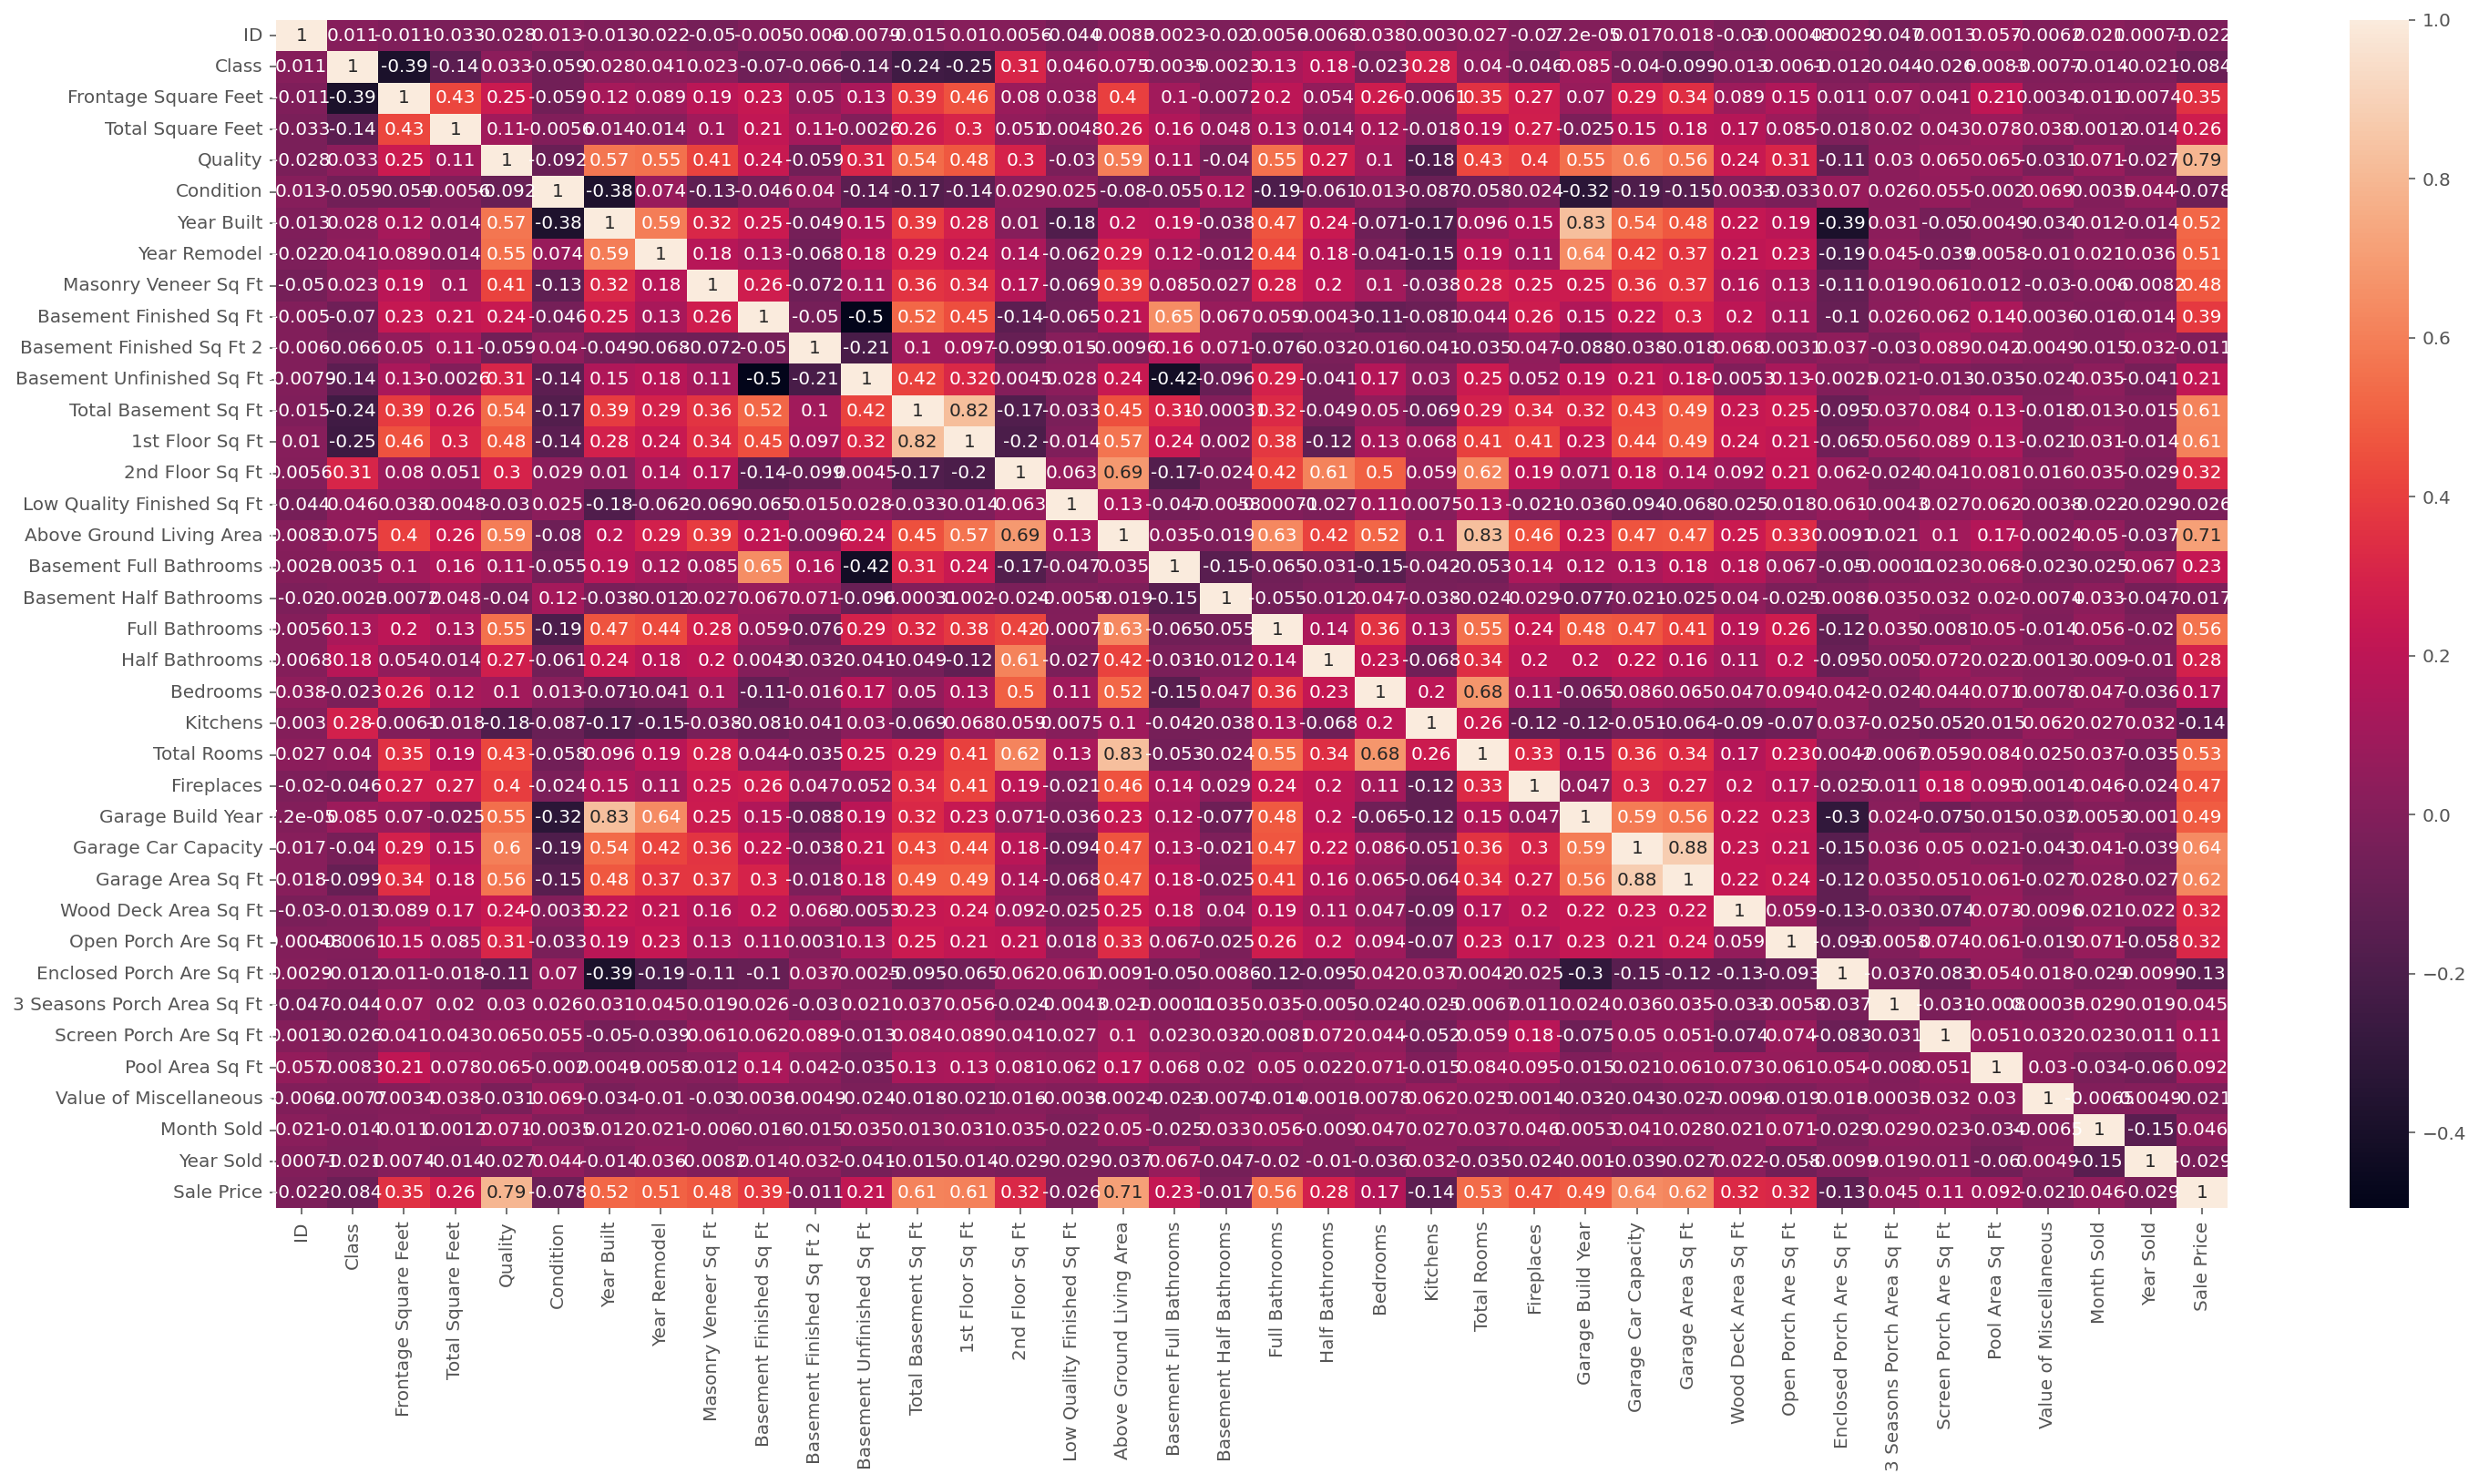

In [6]:
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(ames.corr(), annot=True)
plt.show()

In [7]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 495 to 691
Data columns (total 81 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           1460 non-null   int64  
 1   Class                        1460 non-null   int64  
 2   Zoning                       1460 non-null   object 
 3   Frontage Square Feet         1201 non-null   float64
 4   Total Square Feet            1460 non-null   int64  
 5   Road Access                  1460 non-null   object 
 6   Alley Access                 91 non-null     object 
 7   Shape                        1460 non-null   object 
 8   Flatness                     1460 non-null   object 
 9   Utilities                    1460 non-null   object 
 10  Configuration                1460 non-null   object 
 11  Slope                        1460 non-null   object 
 12  Neighborhood                 1460 non-null   object 
 13  Proximity to Cond

In [8]:
ames.shape

(1460, 81)

In [9]:
ames.describe()

,ID,Class,Frontage Square Feet,Total Square Feet,Quality,Condition,Year Built,Year Remodel,Masonry Veneer Sq Ft,Basement Finished Sq Ft,...,Wood Deck Area Sq Ft,Open Porch Are Sq Ft,Enclosed Porch Are Sq Ft,3 Seasons Porch Area Sq Ft,Screen Porch Are Sq Ft,Pool Area Sq Ft,Value of Miscellaneous,Month Sold,Year Sold,Sale Price
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
# 1. ***Develop an algorithm to reliably estimate the value of residential houses based on fixed characteristics.***
# Firstly, given the above, we can remove any houses that are not residential from the dataset.
ames = ames[ames['Zoning'].isin(['RH','RL','RP','RM'])]
ames.head()
print(ames.shape)

(1385, 81)


In [11]:
# Secondly, we need to focus on 'fixed' characteristics as per #1. Then look at remaining characteristics that ARE renovatable. I can subset these.
# But first, I'll check which columns have null values and check how important they are; i.e. can they be dropped?
ames.isnull()
ames.isnull().sum().sort_values(ascending=False)
print(ames.isnull().sum().sort_values(ascending=False)[ames.isnull().sum().sort_values(ascending=False) > 0])

Pool Quality              1378
Misc Features             1333
Alley Access              1320
Fence Quality             1108
Fireplace Quality          641
Frontage Square Feet       251
Garage Build Year           79
Garage Condition            79
Garage Location             79
Garage Interior Finish      79
Garage Quality              79
Basement Rating 2           38
Basement Exposure           38
Basement Height             37
Basement Condition          37
Basement Rating             37
Masonry Veneer Sq Ft         5
Masonry Veneer Type          5
Electrical System            1
dtype: int64


In [12]:
ames[ames.isnull().sum(axis=1)>0]

,ID,Class,Zoning,Frontage Square Feet,Total Square Feet,Road Access,Alley Access,Shape,Flatness,Utilities,...,Pool Area Sq Ft,Pool Quality,Fence Quality,Misc Features,Value of Miscellaneous,Month Sold,Year Sold,Sale Type,Condition of Sale,Sale Price
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,37900
533,534,20,RL,50.0,5000,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,39300
710,711,30,RL,56.0,4130,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,52000
1337,1338,30,RM,153.0,4118,Pave,Grvl,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2006,WD,Normal,52500
705,706,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [13]:
# Checking null values here, do I drop?

# ames['Pool Quality'].info()
# print(ames['Pool Quality'].value_counts())

# ames['Misc Features'].info()
# print(ames['Misc Features'].value_counts())

# ames['Alley Access'].info()
# print(ames['Alley Access'].value_counts())

# ames['Alley Access'].info()
# print(ames['Alley Access'].value_counts())

# ames['Fence Quality'].info()
# print(ames['Fence Quality'].value_counts())

# ames['Fireplace Quality'].info()
# print(ames['Fireplace Quality'].value_counts())

# ames['Frontage Square Feet'].info()
# print(ames['Frontage Square Feet'].value_counts())

ames['Electrical System'].info()
# print(ames['Electrical System'].value_counts())
print(ames['Electrical System'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
Int64Index: 1385 entries, 968 to 691
Series name: Electrical System
Non-Null Count  Dtype 
--------------  ----- 
1384 non-null   object
dtypes: object(1)
memory usage: 21.6+ KB
SBrkr    1263
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical System, dtype: int64


In [14]:
# drop unwanted columns.

# Of the columns with null values I decided to drop below, each with a reason:

# ID - No null values but its basically an index, which we already have
# Pool Quality              1378 - Dropping because only 7 properties in total had pools, and having a pool covered in pool area column
# Misc Features             1333 - Dropping because only 52 non-null values and 47 of those was sheds, I can't see how this can give us anything meaningful
# Alley Access              1320 - Dropping because only 65 non-null values
# Fence Quality             1108 - Dropping due to large null values but also fence quality is a variable that can be easily changed with minimal investment
# Fireplace Quality          641 - Dropping due to large null values but also NA means no fireplace which is covered in 'fireplaces' variable
# Garage Build Year           79 - Most will be same as property year built
# Garage Condition            79 - Speculate this will have little impact on sold price
# Garage Location             79 - Speculate this will have little impact on sold price
# Garage Interior Finish      79 - Speculate this will have little impact on sold price
# Garage Quality              79 - Speculate this will have little impact on sold price
# Basement Rating 2           38 - Speculate this will have little impact on sold price
# Basement Exposure           38 - Speculate this will have little impact on sold price
# Basement Height             37 - Speculate this will have little impact on sold price
# Basement Condition          37 - Speculate this will have little impact on sold price
# Basement Rating             37 - Speculate this will have little impact on sold price
# Masonry Veneer Sq Ft         5 - Speculate this will have little impact on sold price
# Masonry Veneer Type          5 - Speculate this will have little impact on sold price
# Electrical System            1 - Speculate this will have little impact on sold price
# Frontage Square Feet       251 - Will convert NA's to 0, info shown is the same; no frontage square feet... Done all that (below), decided to drop anyway as data not 
# hugely significant

# ames['Frontage Square Feet'].fillna(value='0.0', inplace=True) 
# ames = ames.astype({'Frontage Square Feet':'float64'})

ames = ames.drop(columns=['ID', 'Pool Quality','Misc Features', 'Alley Access', 'Fence Quality', 'Fireplace Quality', 'Garage Build Year', 'Garage Condition',
'Garage Location', 'Garage Interior Finish', 'Garage Quality', 'Basement Rating 2', 'Basement Exposure','Basement Height', 'Basement Condition',
'Basement Rating', 'Masonry Veneer Sq Ft', 'Masonry Veneer Type','Electrical System', 'Frontage Square Feet'])
ames.head()

,Class,Zoning,Total Square Feet,Road Access,Shape,Flatness,Utilities,Configuration,Slope,Neighborhood,...,Enclosed Porch Are Sq Ft,3 Seasons Porch Area Sq Ft,Screen Porch Are Sq Ft,Pool Area Sq Ft,Value of Miscellaneous,Month Sold,Year Sold,Sale Type,Condition of Sale,Sale Price
968,50,RM,5925,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,0,0,0,0,0,5,2009,WD,Abnorml,37900
533,20,RL,5000,Pave,Reg,Low,AllPub,Inside,Mod,BrkSide,...,0,0,0,0,0,1,2007,WD,Normal,39300
710,30,RL,4130,Pave,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,...,0,0,0,0,0,7,2008,WD,Normal,52000
1337,30,RM,4118,Pave,IR1,Bnk,AllPub,Corner,Mod,OldTown,...,0,0,0,0,0,3,2006,WD,Normal,52500
705,190,RM,5600,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,3500,7,2010,WD,Normal,55000


In [15]:
# Now to decide which other columns to drop;

# Dropping

# 'Zoning', - Non-residential already filtered
# 'Road Access', - Speculate this will have little impact on sold price
# 'Shape', - Speculate this will have little impact on sold price
# 'Flatness', - Speculate this will have little impact on sold price
# 'Slope', - Speculate this will have little impact on sold price
# 'Basement Finished Sq Ft', - Speculate this will have little impact on sold price
# 'Basement Finished Sq Ft 2', - Speculate this will have little impact on sold price
# 'Basement Unfinished Sq Ft', - Speculate this will have little impact on sold price
# 'Low Quality Finished Sq Ft', - Speculate this will have little impact on sold price
# 'Basement Full Bathrooms', - Speculate this will have little impact on sold price
# 'Basement Half Bathrooms', - Speculate this will have little impact on sold price
# 'Value of Miscellaneous', - Speculate this will have little impact on sold price
# 'Wood Deck Area Sq Ft', - Speculate this will have little impact on sold price
# 'Open Porch Are Sq Ft', - Speculate this will have little impact on sold price
# 'Enclosed Porch Are Sq Ft', - Speculate this will have little impact on sold price
# '3 Seasons Porch Area Sq Ft', - Speculate this will have little impact on sold price
# 'Screen Porch Are Sq Ft', - Speculate this will have little impact on sold price

# ... # ames.filter(regex='Porch')

ames = ames.drop(columns=['Zoning', 'Road Access','Shape', 'Flatness', 'Slope', 'Basement Finished Sq Ft', 'Basement Finished Sq Ft 2', 
                      'Basement Unfinished Sq Ft', 'Low Quality Finished Sq Ft', 'Basement Full Bathrooms',
                   'Basement Half Bathrooms', 'Garage Car Capacity','Value of Miscellaneous', 'Wood Deck Area Sq Ft', 'Open Porch Are Sq Ft',
                   'Enclosed Porch Are Sq Ft', '3 Seasons Porch Area Sq Ft','Screen Porch Are Sq Ft'])
ames.head()

,Class,Total Square Feet,Utilities,Configuration,Neighborhood,Proximity to Conditions 1,Proximity to Conditions 2,Type,Style,Quality,...,Functionality,Fireplaces,Garage Area Sq Ft,Paved Driveway,Pool Area Sq Ft,Month Sold,Year Sold,Sale Type,Condition of Sale,Sale Price
968,50,5925,AllPub,Inside,OldTown,Norm,Norm,1Fam,1.5Fin,3,...,Typ,0,0,Y,0,5,2009,WD,Abnorml,37900
533,20,5000,AllPub,Inside,BrkSide,Norm,Norm,1Fam,1Story,1,...,Typ,0,0,N,0,1,2007,WD,Normal,39300
710,30,4130,AllPub,Inside,BrkSide,Norm,Norm,1Fam,1Story,3,...,Maj2,0,0,N,0,7,2008,WD,Normal,52000
1337,30,4118,AllPub,Corner,OldTown,Feedr,Norm,1Fam,1Story,4,...,Typ,0,0,N,0,3,2006,WD,Normal,52500
705,190,5600,AllPub,Inside,IDOTRR,Norm,Norm,2fmCon,2Story,4,...,Mod,0,0,N,0,7,2010,WD,Normal,55000


In [16]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 968 to 691
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Class                        1385 non-null   int64 
 1   Total Square Feet            1385 non-null   int64 
 2   Utilities                    1385 non-null   object
 3   Configuration                1385 non-null   object
 4   Neighborhood                 1385 non-null   object
 5   Proximity to Conditions 1    1385 non-null   object
 6   Proximity to Conditions 2    1385 non-null   object
 7   Type                         1385 non-null   object
 8   Style                        1385 non-null   object
 9   Quality                      1385 non-null   int64 
 10  Condition                    1385 non-null   int64 
 11  Year Built                   1385 non-null   int64 
 12  Year Remodel                 1385 non-null   int64 
 13  Roof Style                   138

In [17]:
print(ames.select_dtypes(include='object').columns)
print(ames.select_dtypes(include='float64').columns)
print(ames.select_dtypes(include='int64').columns)

Index(['Utilities', 'Configuration', 'Neighborhood',
       'Proximity to Conditions 1', 'Proximity to Conditions 2', 'Type',
       'Style', 'Roof Style', 'Roof Material', 'Exterior Material',
       'Exterior Material 2', 'Exterior Quality', 'Exterior Condition',
       'Foundation', 'Heating', 'Heating Quality & Condition',
       'Central Air Conditioning', 'Kitchen Quality', 'Functionality',
       'Paved Driveway', 'Sale Type', 'Condition of Sale'],
      dtype='object')
Index([], dtype='object')
Index(['Class', 'Total Square Feet', 'Quality', 'Condition', 'Year Built',
       'Year Remodel', 'Total Basement Sq Ft', '1st Floor Sq Ft',
       '2nd Floor Sq Ft', 'Above Ground Living Area', 'Full Bathrooms',
       'Half Bathrooms', 'Bedrooms', 'Kitchens', 'Total Rooms', 'Fireplaces',
       'Garage Area Sq Ft', 'Pool Area Sq Ft', 'Month Sold', 'Year Sold',
       'Sale Price'],
      dtype='object')


In [18]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 968 to 691
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Class                        1385 non-null   int64 
 1   Total Square Feet            1385 non-null   int64 
 2   Utilities                    1385 non-null   object
 3   Configuration                1385 non-null   object
 4   Neighborhood                 1385 non-null   object
 5   Proximity to Conditions 1    1385 non-null   object
 6   Proximity to Conditions 2    1385 non-null   object
 7   Type                         1385 non-null   object
 8   Style                        1385 non-null   object
 9   Quality                      1385 non-null   int64 
 10  Condition                    1385 non-null   int64 
 11  Year Built                   1385 non-null   int64 
 12  Year Remodel                 1385 non-null   int64 
 13  Roof Style                   138

In [19]:
# Identify fixed features that can predict price. 

# Fixed

# 'Class', 
# 'Total Square Feet',
# 'Frontage Square Feet',
# 'Configuration',
# 'Neighborhood',
# 'Proximity to Conditions 1',
# 'Proximity to Conditions 2',
# 'Type',
# 'Style',
# 'Year Built',
# 'Year Remodel',
# 'Foundation',
# 'Total Basement Sq Ft',
# '1st Floor Sq Ft',
# '2nd Floor Sq Ft',
# 'Above Ground Living Area',
# 'Full Bathrooms',
# 'Full Bathrooms',
# 'Half Bathrooms',
# 'Bedrooms',
# 'Kitchens',
# 'Total Rooms',
# 'Garade Area Sq Ft',
# 'Pool Area Sq Ft',

fixed = ames[['Class', 'Total Square Feet', 'Configuration', 'Neighborhood', 'Proximity to Conditions 1', 'Proximity to Conditions 2', 'Type',
'Style', 'Year Built', 'Year Remodel', 'Foundation', 'Total Basement Sq Ft', '1st Floor Sq Ft', '2nd Floor Sq Ft', 'Above Ground Living Area',
              'Full Bathrooms', 'Half Bathrooms',
'Bedrooms', 'Kitchens', 'Total Rooms', 'Garage Area Sq Ft','Pool Area Sq Ft','Month Sold', 'Year Sold', 'Sale Type',
       'Condition of Sale', 'Sale Price']]
fixed.head()

,Class,Total Square Feet,Configuration,Neighborhood,Proximity to Conditions 1,Proximity to Conditions 2,Type,Style,Year Built,Year Remodel,...,Bedrooms,Kitchens,Total Rooms,Garage Area Sq Ft,Pool Area Sq Ft,Month Sold,Year Sold,Sale Type,Condition of Sale,Sale Price
968,50,5925,Inside,OldTown,Norm,Norm,1Fam,1.5Fin,1910,1950,...,2,1,6,0,0,5,2009,WD,Abnorml,37900
533,20,5000,Inside,BrkSide,Norm,Norm,1Fam,1Story,1946,1950,...,1,1,2,0,0,1,2007,WD,Normal,39300
710,30,4130,Inside,BrkSide,Norm,Norm,1Fam,1Story,1935,2003,...,2,1,5,0,0,7,2008,WD,Normal,52000
1337,30,4118,Corner,OldTown,Feedr,Norm,1Fam,1Story,1941,1950,...,2,1,4,0,0,3,2006,WD,Normal,52500
705,190,5600,Inside,IDOTRR,Norm,Norm,2fmCon,2Story,1930,1950,...,3,2,7,0,0,7,2010,WD,Normal,55000


<AxesSubplot:>

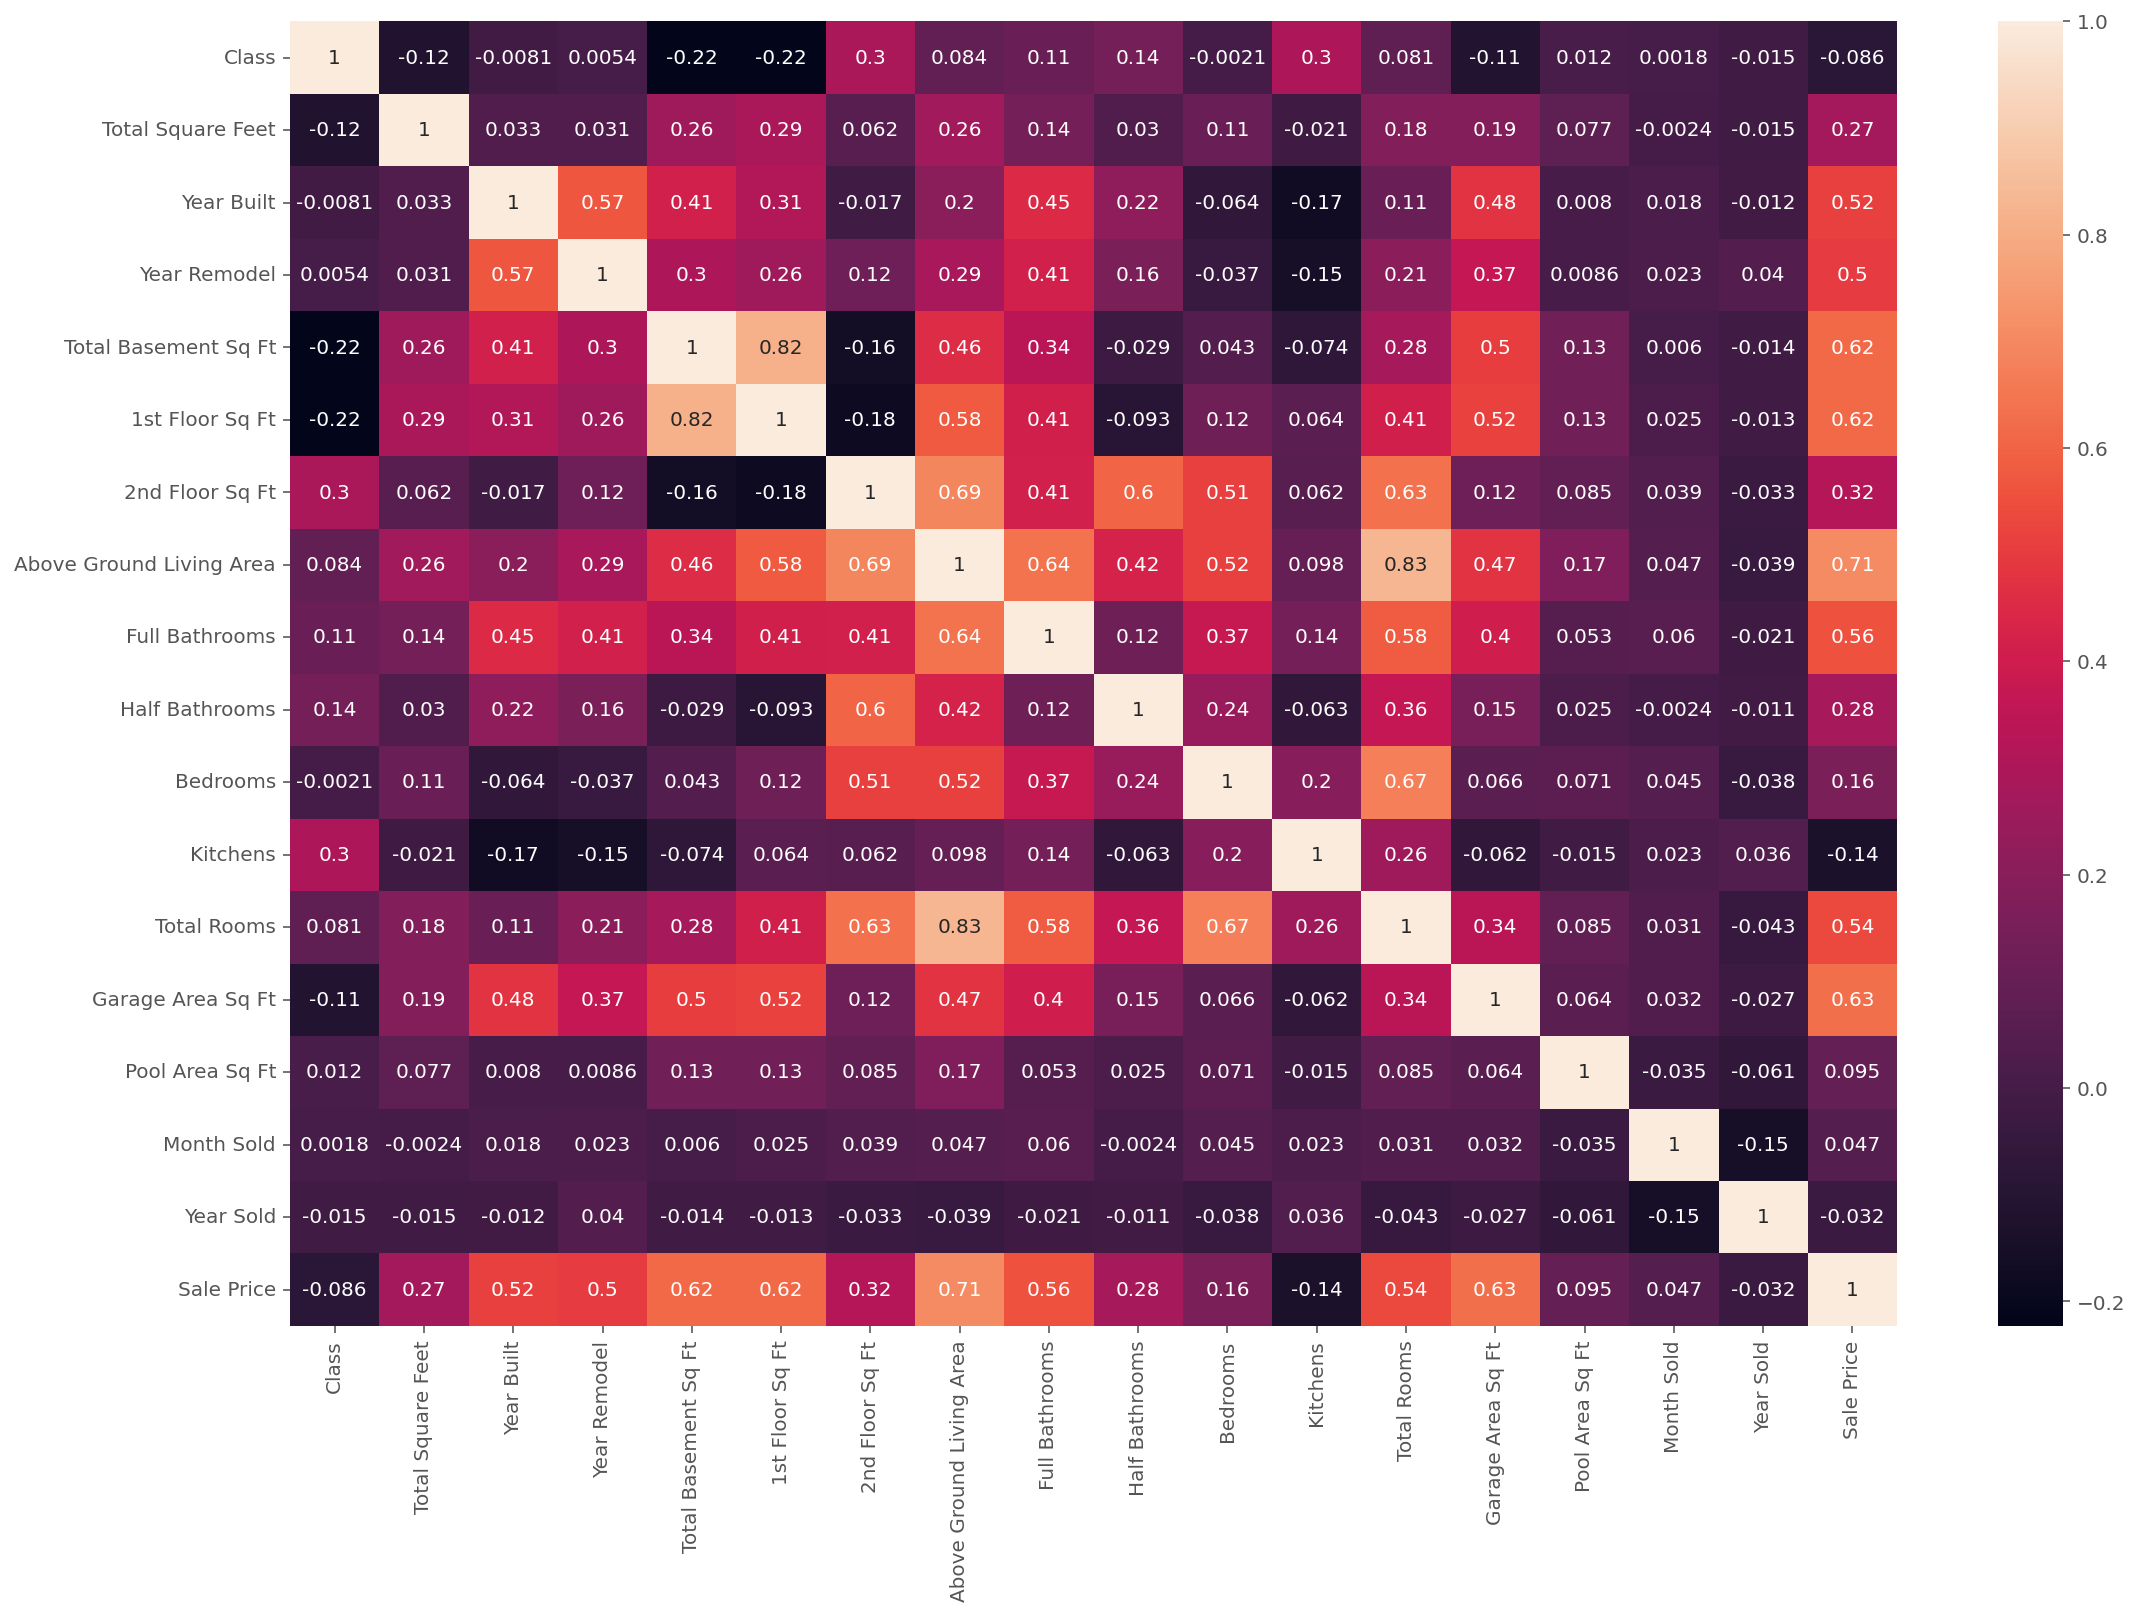

In [20]:
plt.figure(figsize=(18,12))
sns.heatmap(fixed.corr(), annot=True)

In [21]:
# print(fixed.keys())
print(fixed.columns)
fixed.head()

Index(['Class', 'Total Square Feet', 'Configuration', 'Neighborhood',
       'Proximity to Conditions 1', 'Proximity to Conditions 2', 'Type',
       'Style', 'Year Built', 'Year Remodel', 'Foundation',
       'Total Basement Sq Ft', '1st Floor Sq Ft', '2nd Floor Sq Ft',
       'Above Ground Living Area', 'Full Bathrooms', 'Half Bathrooms',
       'Bedrooms', 'Kitchens', 'Total Rooms', 'Garage Area Sq Ft',
       'Pool Area Sq Ft', 'Month Sold', 'Year Sold', 'Sale Type',
       'Condition of Sale', 'Sale Price'],
      dtype='object')


,Class,Total Square Feet,Configuration,Neighborhood,Proximity to Conditions 1,Proximity to Conditions 2,Type,Style,Year Built,Year Remodel,...,Bedrooms,Kitchens,Total Rooms,Garage Area Sq Ft,Pool Area Sq Ft,Month Sold,Year Sold,Sale Type,Condition of Sale,Sale Price
968,50,5925,Inside,OldTown,Norm,Norm,1Fam,1.5Fin,1910,1950,...,2,1,6,0,0,5,2009,WD,Abnorml,37900
533,20,5000,Inside,BrkSide,Norm,Norm,1Fam,1Story,1946,1950,...,1,1,2,0,0,1,2007,WD,Normal,39300
710,30,4130,Inside,BrkSide,Norm,Norm,1Fam,1Story,1935,2003,...,2,1,5,0,0,7,2008,WD,Normal,52000
1337,30,4118,Corner,OldTown,Feedr,Norm,1Fam,1Story,1941,1950,...,2,1,4,0,0,3,2006,WD,Normal,52500
705,190,5600,Inside,IDOTRR,Norm,Norm,2fmCon,2Story,1930,1950,...,3,2,7,0,0,7,2010,WD,Normal,55000


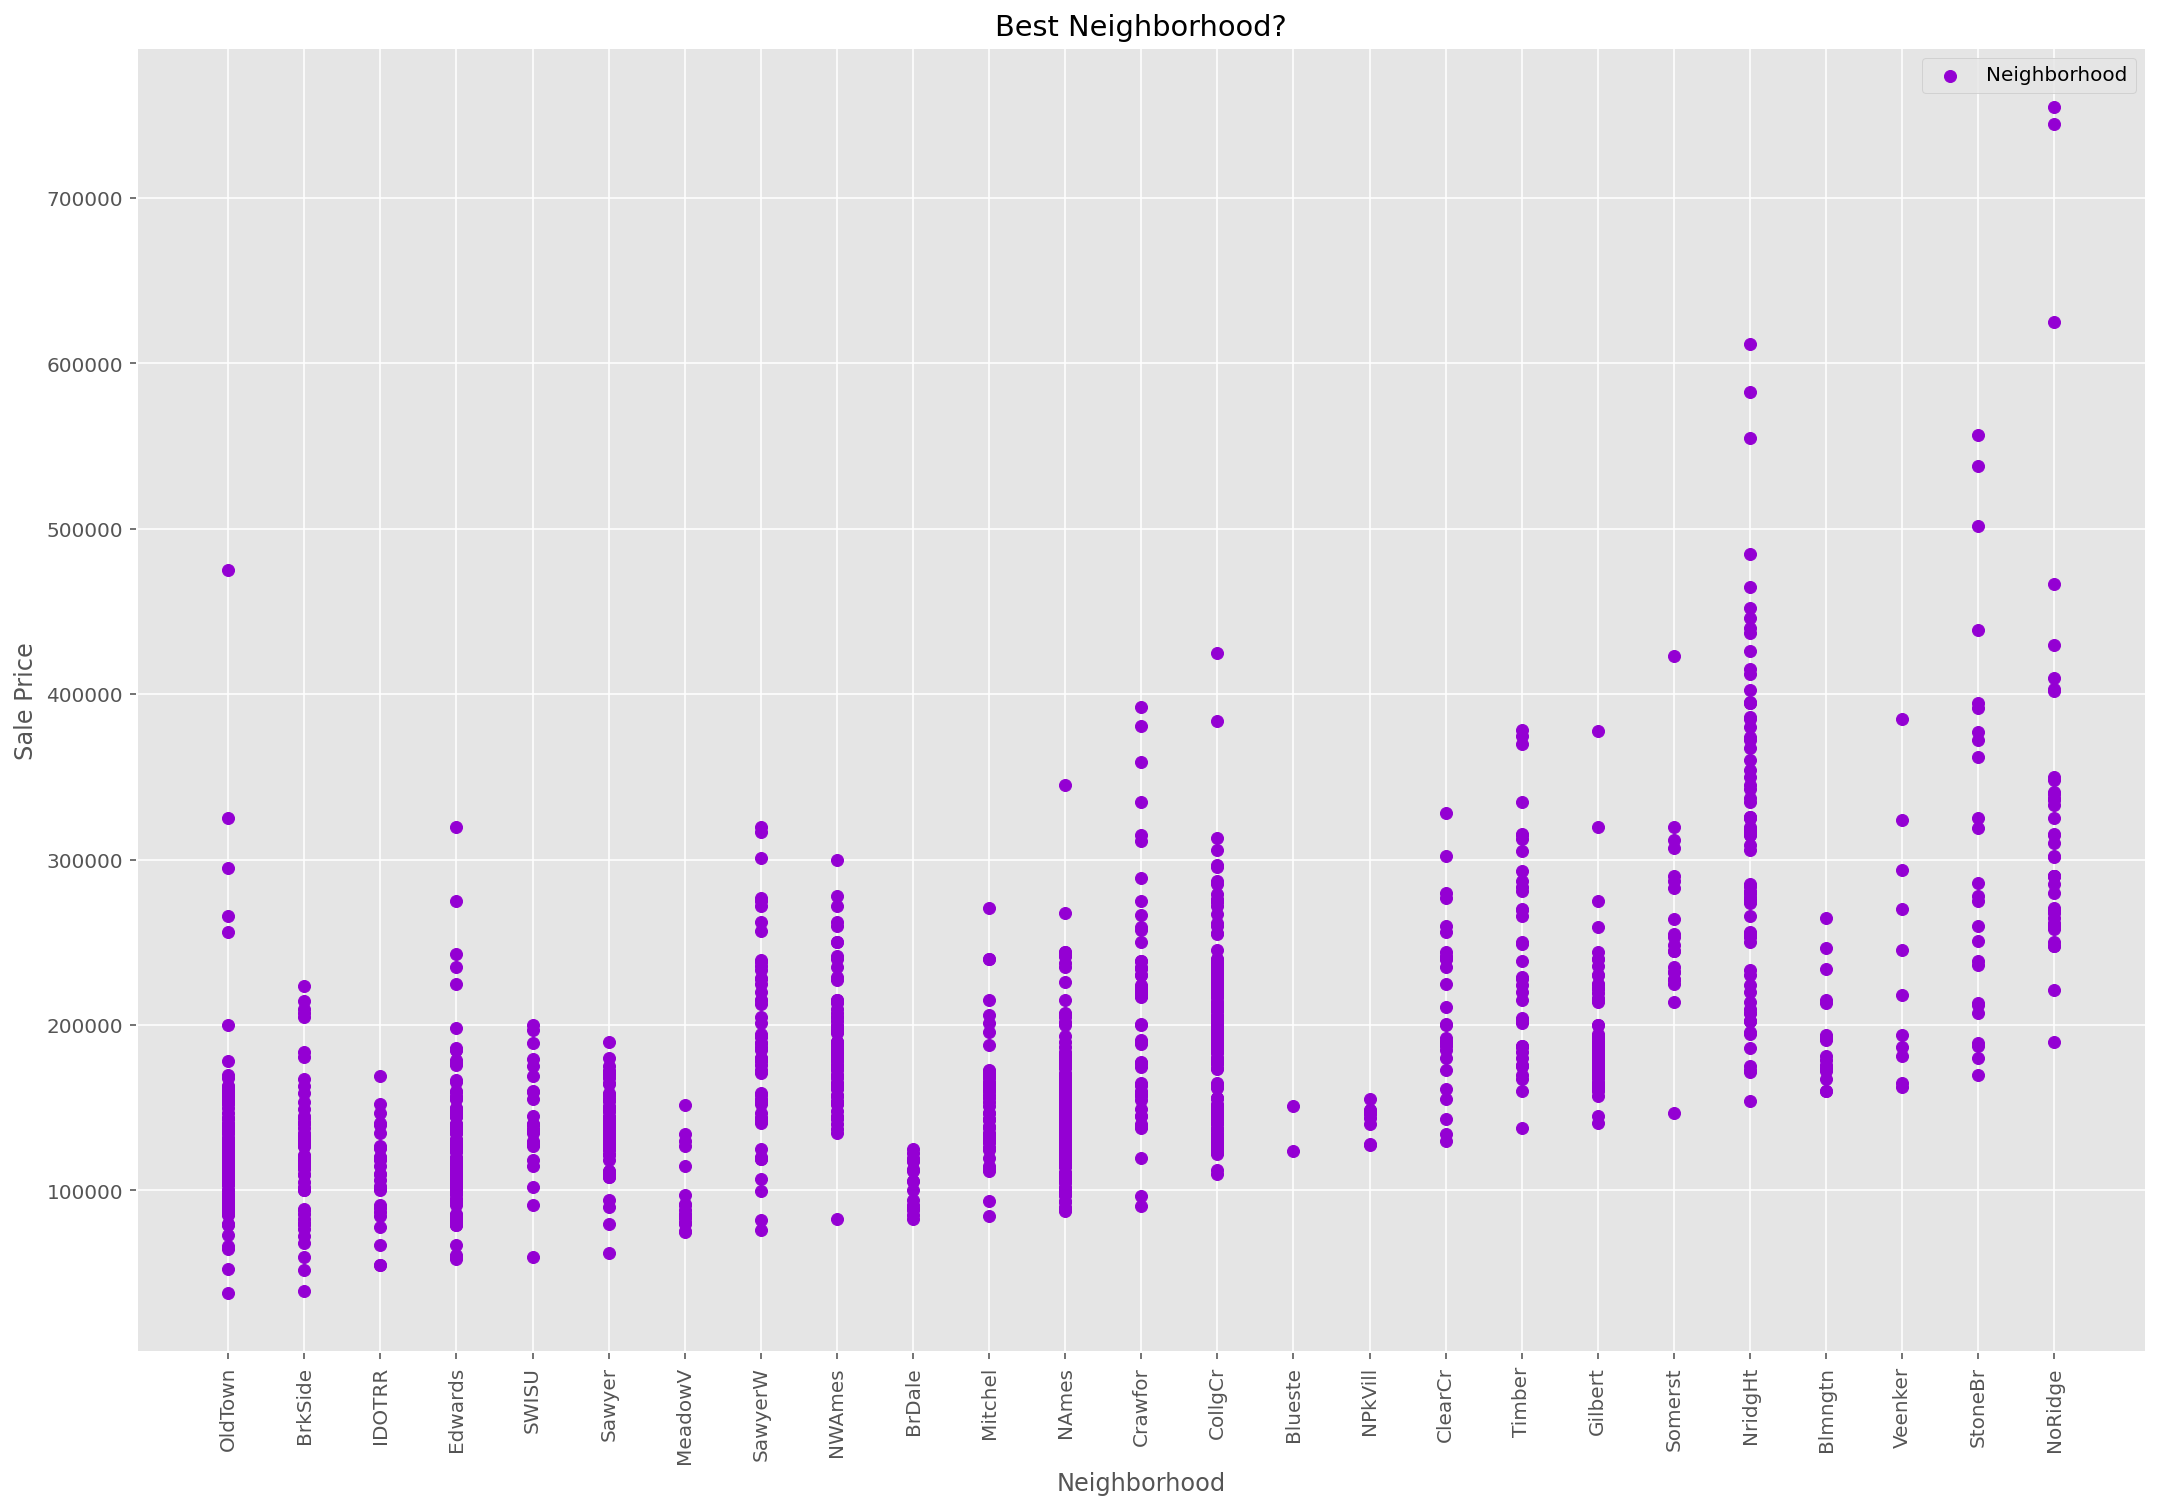

In [22]:
# Demonstrates the best neighborhoods most correlated to price = categorical
plt.figure(figsize=(18,12))
plt.scatter(fixed['Neighborhood'], fixed['Sale Price'],  c = "darkviolet",label='Neighborhood')
plt.legend(loc='upper right')
plt.xlabel('Neighborhood')
plt.xticks(rotation=90)
plt.ylabel('Sale Price')
plt.title('Best Neighborhood?')
plt.show()

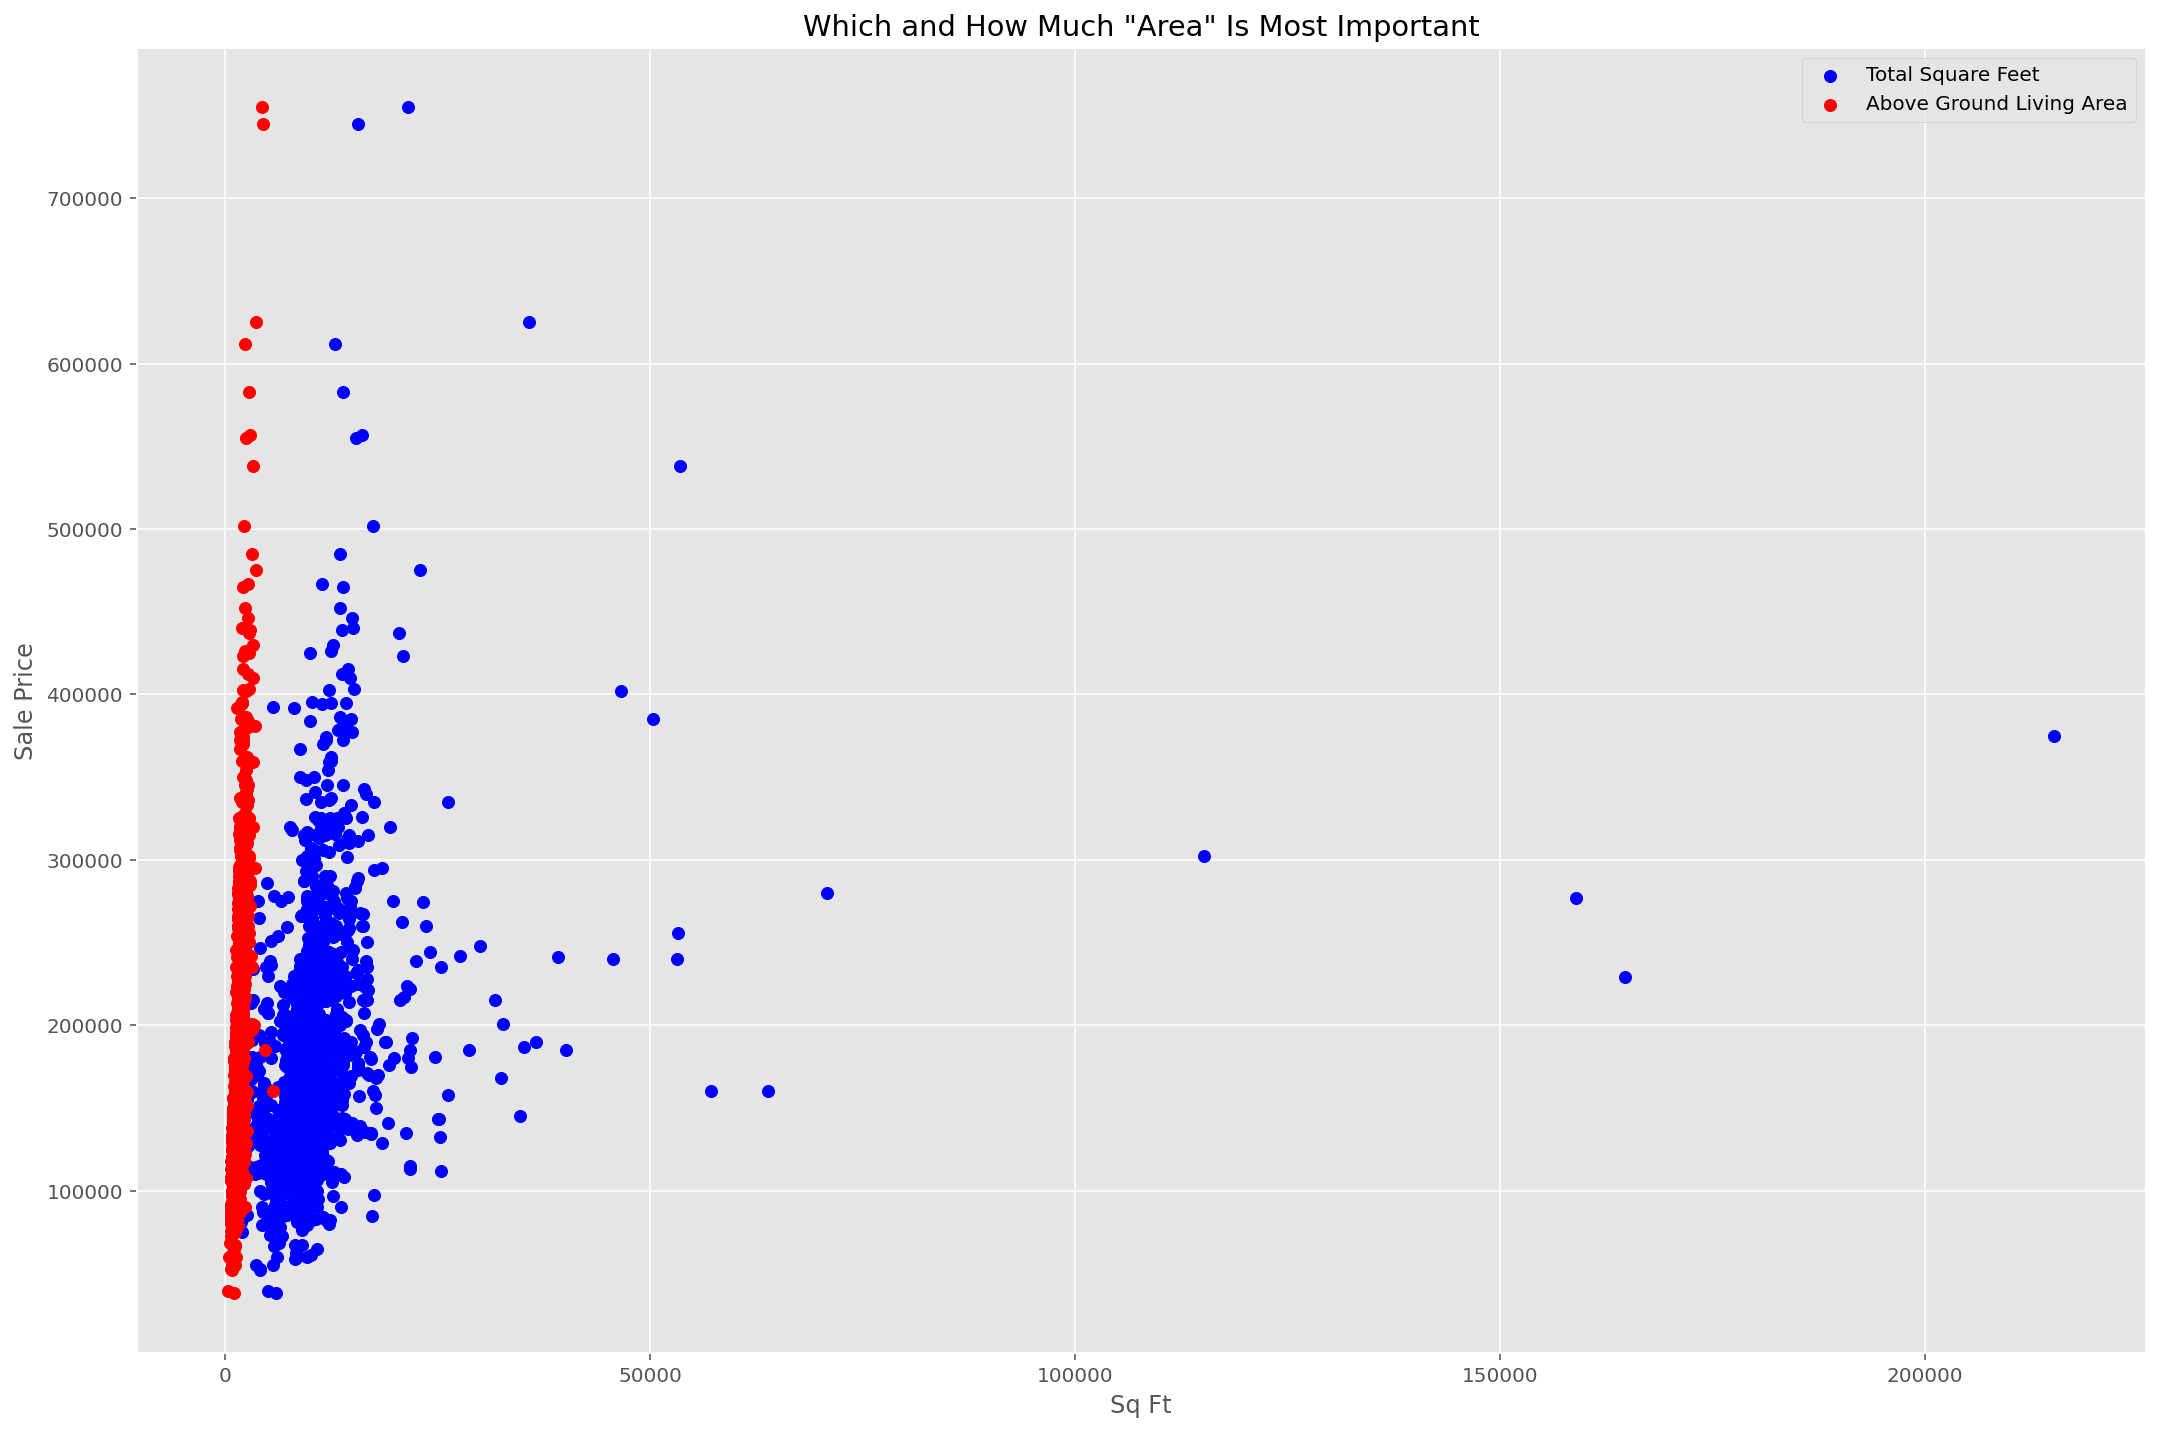

In [23]:
# Which vs how much sq ft area? Sq ft = continuous
plt.figure(figsize=(18,12))
plt.scatter(fixed['Total Square Feet'], fixed['Sale Price'], c = "blue",label='Total Square Feet')
plt.scatter(fixed['Above Ground Living Area'], fixed['Sale Price'], c = "red", label='Above Ground Living Area')
# plt.scatter(fixed['Garage Area Sq Ft'], fixed['Sale Price'], c = "blue",label='Garage Area Sq Ft')
# plt.scatter(fixed['Frontage Square Feet'], fixed['Sale Price'], c = "orange",label='Frontage Square Feet')
#plt.plot([fixed['Sale Price'].min(), fixed['Sale Price'].max()], [fixed['Sale Price'].min(), fixed['Sale Price'].max()], c='k', lw=1)
plt.legend(loc='upper right')
plt.xlabel('Sq Ft')
plt.ylabel('Sale Price')
plt.title('Which and How Much "Area" Is Most Important')
plt.show()
# above ground living area is a stronger predictor of price than total square feet of house

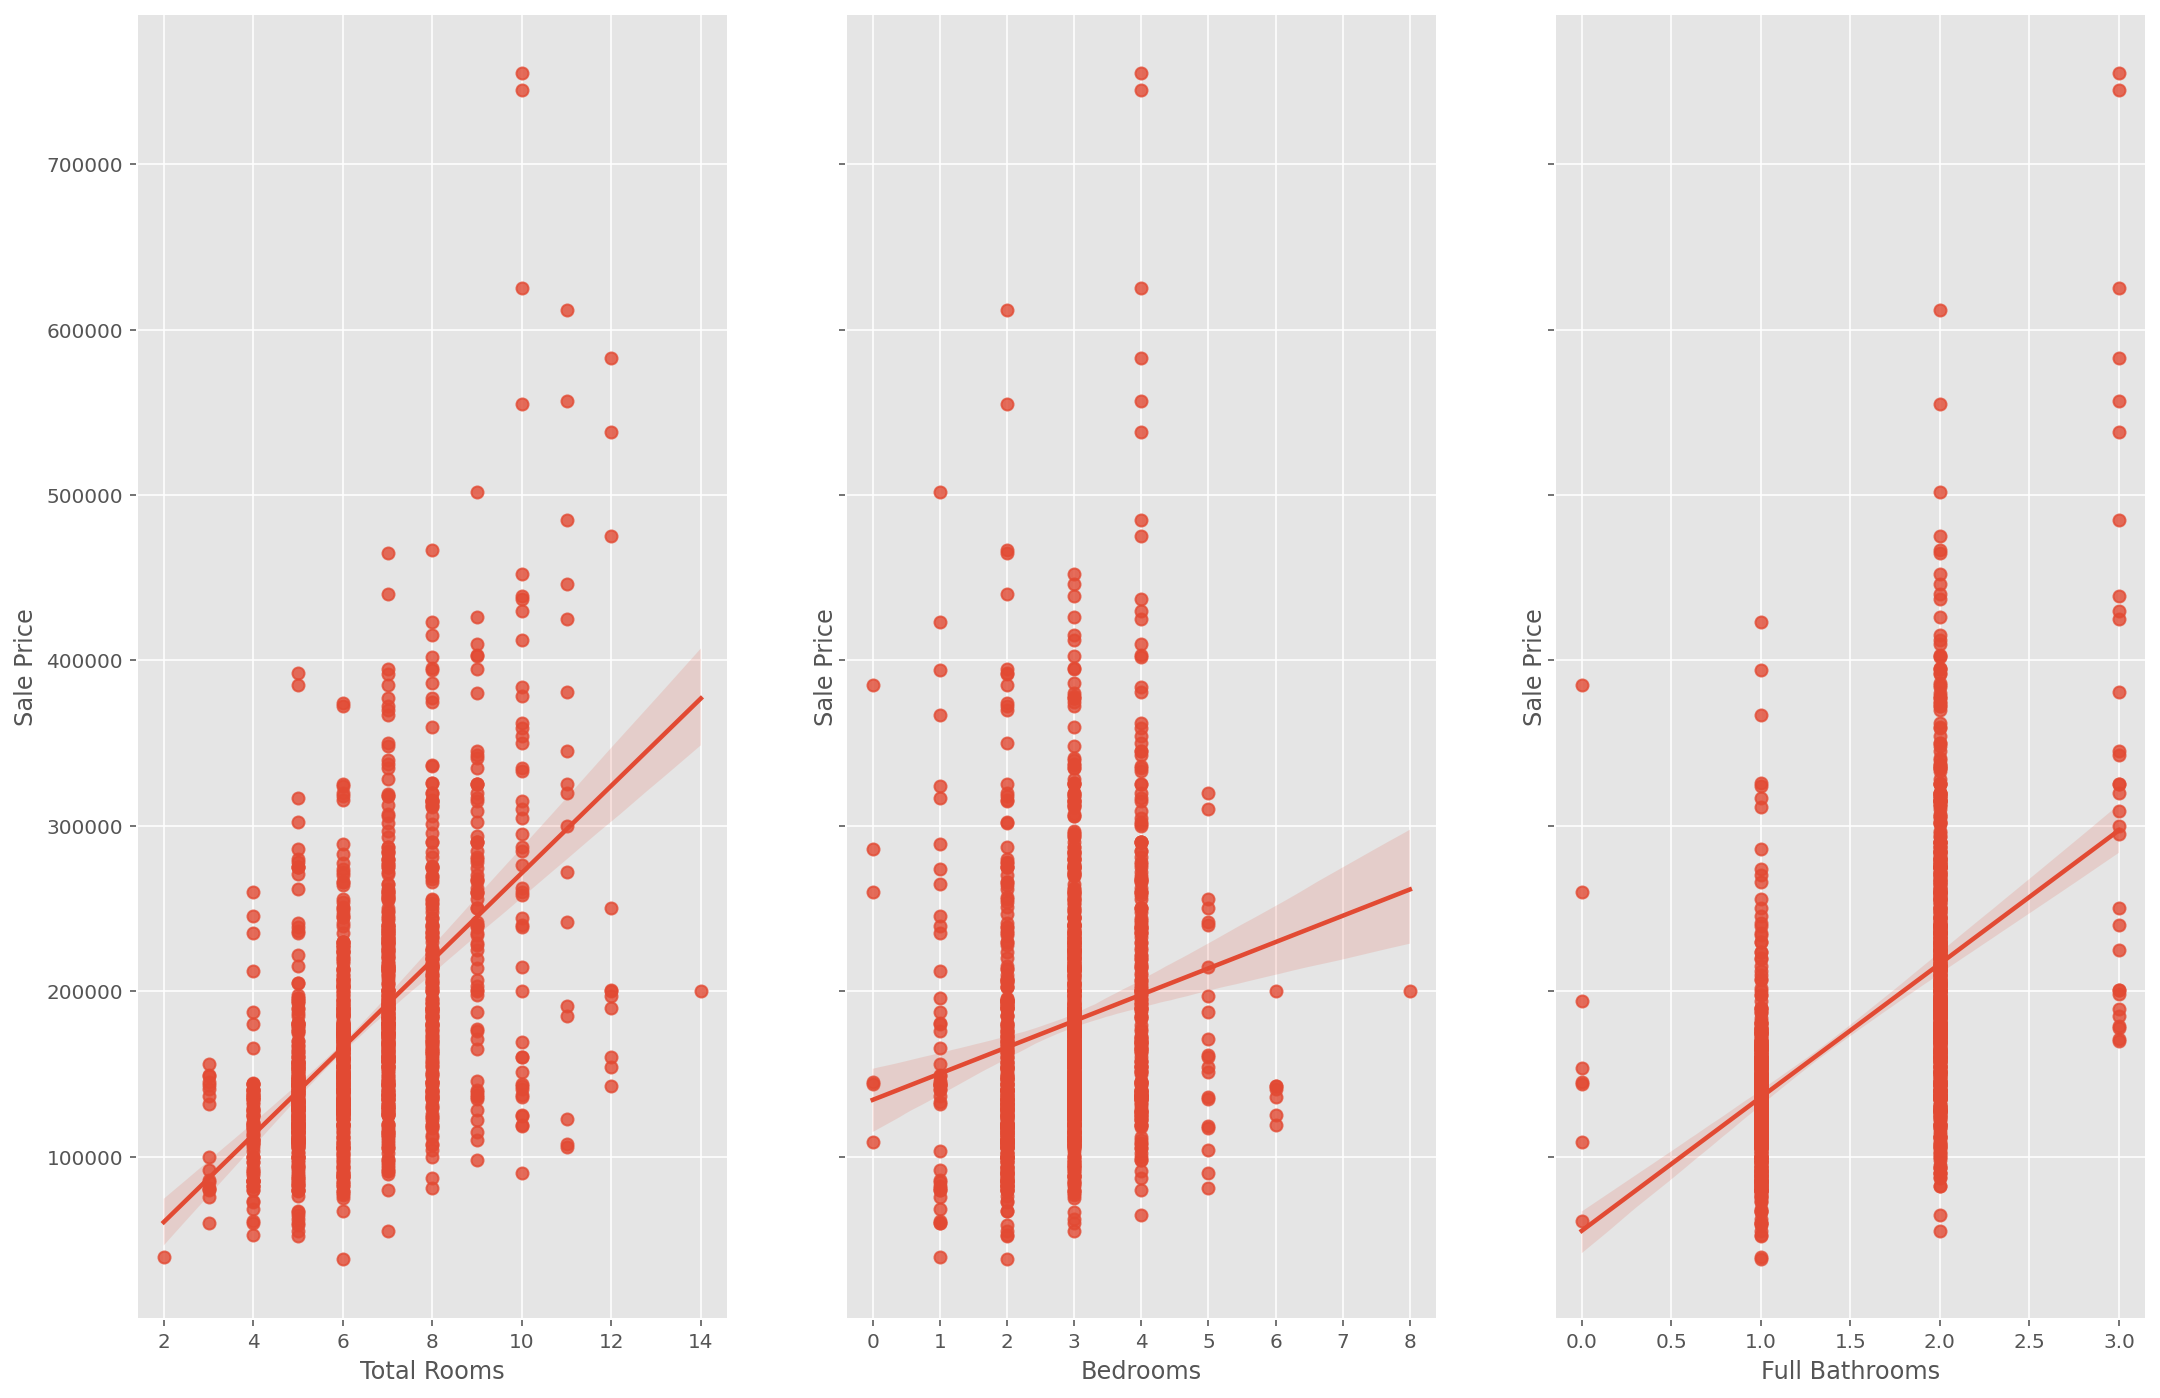

In [24]:
# How many rooms? = Discrete variables

fig, ax = plt.subplots(ncols=3, figsize=(18, 12), sharey=True)
sns.regplot(x='Total Rooms', y='Sale Price', data=fixed, ax=ax[0])
sns.regplot(x='Bedrooms', y='Sale Price', data=fixed, ax=ax[1])
sns.regplot(x='Full Bathrooms', y='Sale Price',  data=fixed, ax=ax[2])
plt.show()

So far, just looking visually at the data, my assumptions are that neighborhood is the most important predictor of price over any other variable. Then above ground living area, then total rooms

... Now to look at the target variable...

In [25]:
fixed['Sale Price'].describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: Sale Price, dtype: float64

In [26]:
# Empirical Rule
fixed['Sale Price'].describe()['mean'] + (3 * fixed['Sale Price'].describe()['std'])

419855.3728740337

In [27]:
fixed['Sale Price'].describe()['75%'] + (1.5 * (fixed['Sale Price'].describe()['75%'] - fixed['Sale Price'].describe()['25%']))

338750.0

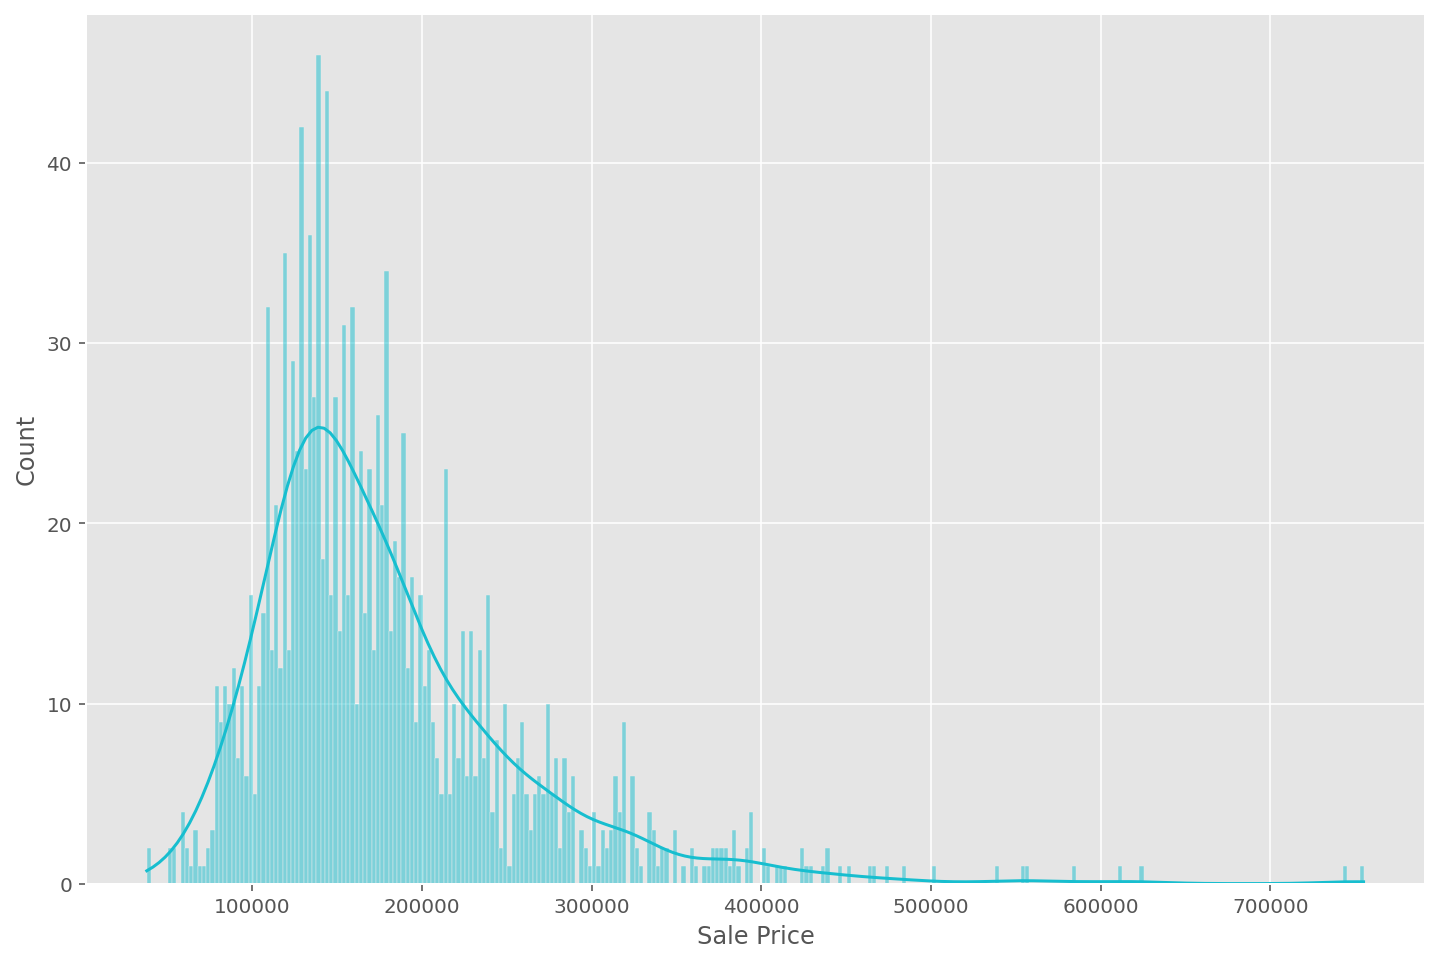

In [28]:
figure = plt.figure(figsize=(12,8))
sns.histplot(fixed['Sale Price'],stat='count',binwidth=2500, color='tab:cyan', kde=True)
plt.show()

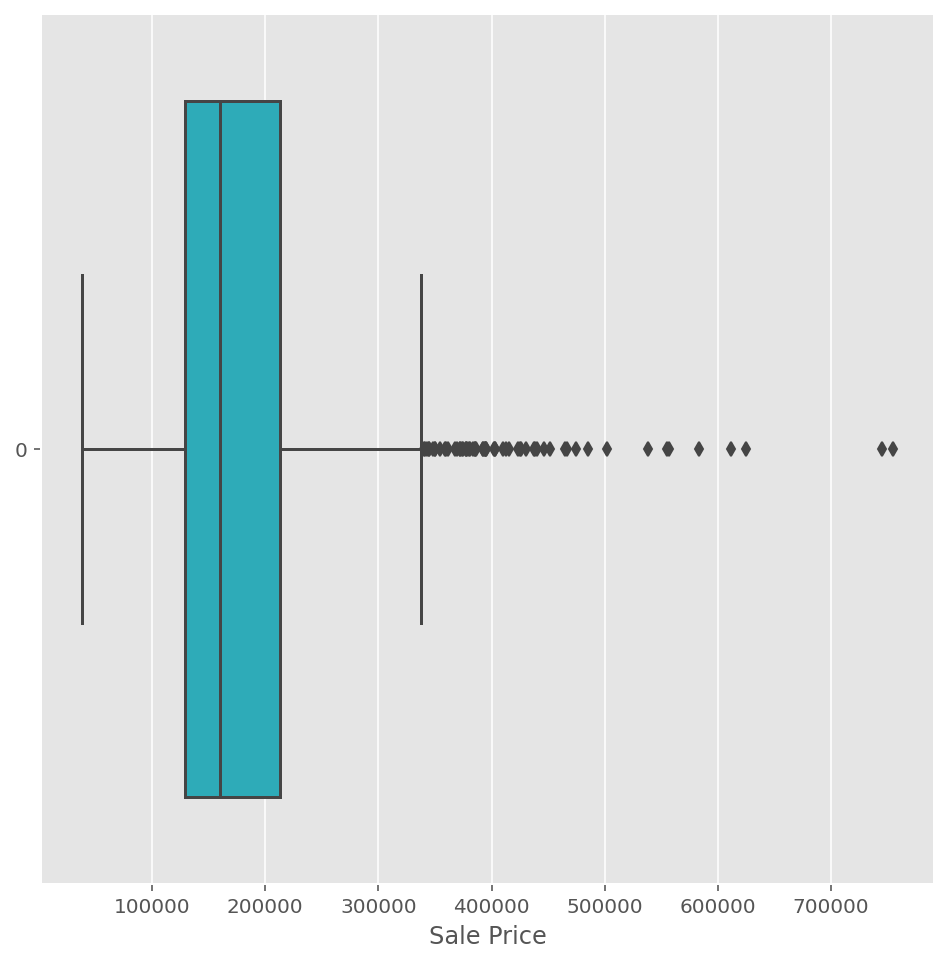

In [29]:
fig = plt.figure(figsize=(8,8))
sns.boxplot(data=fixed['Sale Price'],orient='h',whis=1.5,color='tab:cyan')
plt.xlabel('Sale Price')
plt.show();

Right-skewed distribution

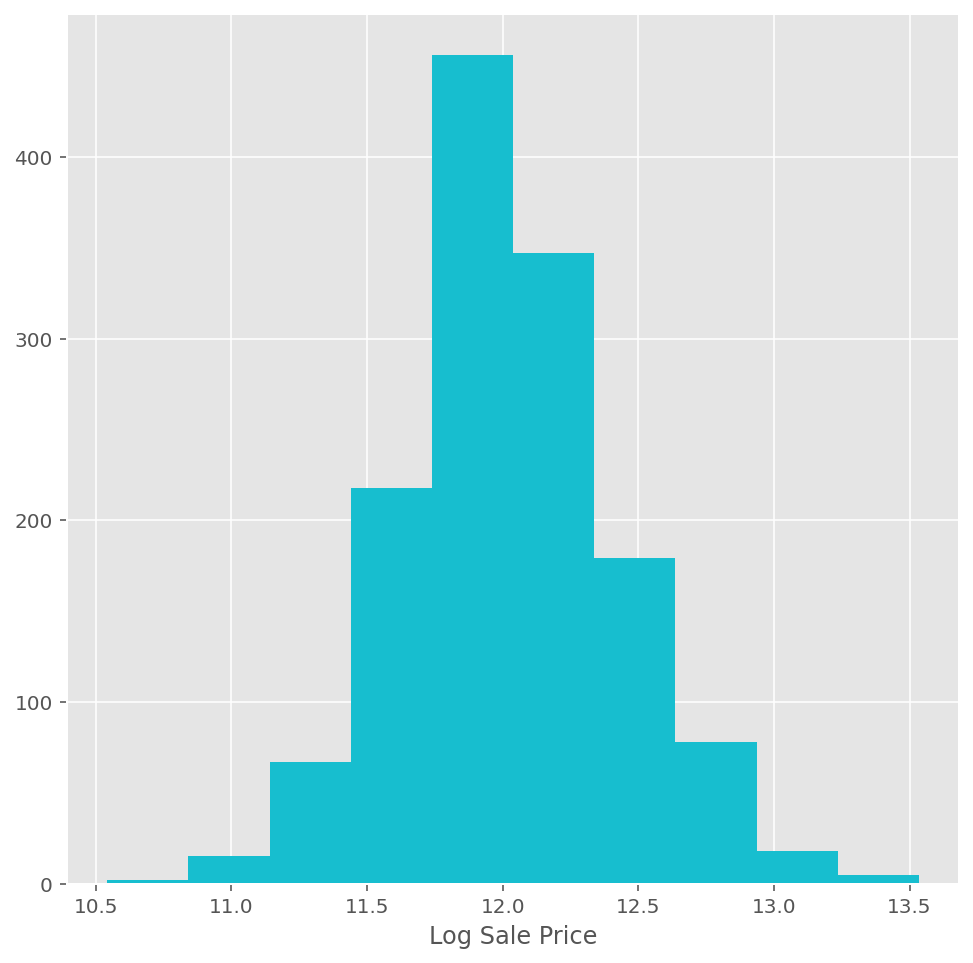

In [30]:
fig = plt.figure(figsize=(8,8))
np.log(fixed['Sale Price']).hist(color='tab:cyan')
plt.xlabel('Log Sale Price')
plt.show();

In [31]:
print(fixed.select_dtypes(include='object').columns)

Index(['Configuration', 'Neighborhood', 'Proximity to Conditions 1',
       'Proximity to Conditions 2', 'Type', 'Style', 'Foundation', 'Sale Type',
       'Condition of Sale'],
      dtype='object')


In [32]:
# Dummify categorical variables 

pd.options.mode.chained_assignment = None

lbl = LabelEncoder()

fixed['Configuration'] = lbl.fit_transform(fixed['Configuration'])
fixed['Neighborhood'] = lbl.fit_transform(fixed['Neighborhood'])
fixed['Proximity to Conditions 1'] = lbl.fit_transform(fixed['Proximity to Conditions 1'])
fixed['Proximity to Conditions 2'] = lbl.fit_transform(fixed['Proximity to Conditions 2'])
fixed['Type'] = lbl.fit_transform(fixed['Type'])
fixed['Style'] = lbl.fit_transform(fixed['Style'])
fixed['Foundation'] = lbl.fit_transform(fixed['Foundation'])
fixed['Sale Type'] = lbl.fit_transform(fixed['Sale Type'])
fixed['Condition of Sale'] = lbl.fit_transform(fixed['Condition of Sale'])

fixed

,Class,Total Square Feet,Configuration,Neighborhood,Proximity to Conditions 1,Proximity to Conditions 2,Type,Style,Year Built,Year Remodel,...,Bedrooms,Kitchens,Total Rooms,Garage Area Sq Ft,Pool Area Sq Ft,Month Sold,Year Sold,Sale Type,Condition of Sale,Sale Price
968,50,5925,4,17,2,2,0,0,1910,1950,...,2,1,6,0,0,5,2009,8,0,37900
533,20,5000,4,3,2,2,0,2,1946,1950,...,1,1,2,0,0,1,2007,8,4,39300
710,30,4130,4,3,2,2,0,2,1935,2003,...,2,1,5,0,0,7,2008,8,4,52000
1337,30,4118,0,17,1,2,0,2,1941,1950,...,2,1,4,0,0,3,2006,8,4,52500
705,190,5600,4,9,2,2,1,5,1930,1950,...,3,2,7,0,0,7,2010,8,4,55000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,60,13891,4,16,2,2,0,5,2008,2009,...,4,1,12,1020,0,1,2009,6,5,582933
898,20,12919,4,16,2,2,0,2,2009,2010,...,2,1,11,820,0,3,2010,6,5,611657
1169,60,35760,1,15,2,2,0,5,1995,1996,...,4,1,10,807,0,7,2006,8,4,625000
1182,60,15623,0,15,2,2,0,5,1996,1996,...,4,1,10,813,555,7,2007,8,0,745000


In [33]:
# Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
# train set should be based on pre 2010 data
# test set should be based on 2010 data
# Train test based on Year Sold column - filter or further subset your data
fixed_train = fixed[fixed['Year Sold'] < 2010].copy()
fixed_test = fixed[fixed['Year Sold'] == 2010].copy()

In [34]:
# specify predictor matrix and target variable
X = fixed_train.drop(columns='Sale Price')
y = fixed_train[['Sale Price']]

In [35]:
# get train-test split (50/50)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=26)

In [36]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(610, 26) (610, 1)
(611, 26) (611, 1)


In [37]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [38]:
# create a linear regression model instance
model = LinearRegression()
# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training R2 Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test R2 Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.81009416 0.84772911 0.77327216 0.78590354 0.7486393 ]
Mean cross-validated training score: 0.7931276540074378
Training R2 Score: 0.8356828278001004
Test R2 Score: 0.5507100675240495


In [39]:
model.fit(X, y)
predictions = model.predict(X)
r2score = model.score(X, y)
print('R2 score:', model.score(X, y))
print('Intercept:', model.intercept_)
print('Coefficient:', model.coef_)

R2 score: 0.7518637557128727
Intercept: [776361.8260648]
Coefficient: [[-4.09607675e+00  3.61337865e-01  4.04655446e+01  9.26383747e+02
  -8.19678225e+02 -1.08189468e+04 -3.37854912e+03 -6.17423916e+02
   4.51958187e+02  3.95802548e+02  2.25443299e+03  2.66648079e+01
   5.47120032e+01  5.42225256e+01  1.54140847e+01  4.67334119e+03
  -3.06480163e+02 -1.47710732e+04 -4.03439974e+04  5.56278085e+03
   4.66051313e+01 -2.87728089e+01  5.71362880e+02 -1.19341732e+03
   2.91752973e+02  3.28466732e+03]]


In [40]:
# create a ridge model instance
ridge = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
# get the best alpha
print('Best alpha:', ridge.alphas)
# get cross validated scores
r_scores = cross_val_score(ridge, X_train, y_train, cv=5)
print("Cross-validated training scores:", r_scores)
print("Mean cross-validated training score:", r_scores.mean())
# fit and evaluate the data on the whole training set
ridge.fit(X_train, y_train)
print("Training R2 Score:", ridge.score(X_train, y_train))
# evaluate the data on the test set
print("Test R2 Score:", ridge.score(X_test, y_test))

Best alpha: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Cross-validated training scores: [0.80462611 0.84774492 0.77825485 0.79678361 0.74848111]
Mean cross-validated training score: 0.7951781196972052
Training R2 Score: 0.8356828277944229
Test R2 Score: 0.5507104680497737


In [42]:
# create a lasso model instance
lasso = LassoCV(alphas=np.linspace(705, 710, 100), cv=5, max_iter=1000)
# fit the model
lasso.fit(X_train, np.ravel(y_train,order='C'))
# get the best alpha
print('Best alpha:', lasso.alphas)
# get cross validated scores
l_scores = cross_val_score(lasso, X_train, np.ravel(y_train,order='C'), cv=5)
print("Cross-validated training scores:", l_scores)
print("Mean cross-validated training score:", l_scores.mean())
print("Training R2 Score:", lasso.score(X_train, np.ravel(y_train,order='C')))
# evaluate the data on the test set
print("Test R2 Score:", lasso.score(X_test, y_test))

Best alpha: [705.         705.05050505 705.1010101  705.15151515 705.2020202
 705.25252525 705.3030303  705.35353535 705.4040404  705.45454545
 705.50505051 705.55555556 705.60606061 705.65656566 705.70707071
 705.75757576 705.80808081 705.85858586 705.90909091 705.95959596
 706.01010101 706.06060606 706.11111111 706.16161616 706.21212121
 706.26262626 706.31313131 706.36363636 706.41414141 706.46464646
 706.51515152 706.56565657 706.61616162 706.66666667 706.71717172
 706.76767677 706.81818182 706.86868687 706.91919192 706.96969697
 707.02020202 707.07070707 707.12121212 707.17171717 707.22222222
 707.27272727 707.32323232 707.37373737 707.42424242 707.47474747
 707.52525253 707.57575758 707.62626263 707.67676768 707.72727273
 707.77777778 707.82828283 707.87878788 707.92929293 707.97979798
 708.03030303 708.08080808 708.13131313 708.18181818 708.23232323
 708.28282828 708.33333333 708.38383838 708.43434343 708.48484848
 708.53535354 708.58585859 708.63636364 708.68686869 708.73737374

In [ ]:
# Characterize your model. How well does it perform? What are the best estimates of price?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# 2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.

# Some examples of things that ARE renovateable:

# Roof and exterior features
# "Quality" metrics, such as kitchen quality
# "Condition" metrics, such as condition of garage
# Heating and electrical components

# Non-fixed

# 'Quality',
# 'Condition',
# 'Utilities',
# 'Roof Style',
# 'Roof Material',
# 'Exterior Material',
# 'Exterior Material 2',
# 'Exterior Quality',
# 'Exterior Condition',
# 'Heating',
# 'Heating Quality & Condition',
# 'Central Air Conditioning',
# 'Kitchen Quality',
# 'Functionality',
# 'Fireplaces',
# 'Paved Driveway',

In [ ]:
ames.columns

In [ ]:
# Roof and exterior features
# "Quality" metrics, such as kitchen quality
# "Condition" metrics, such as condition of garage
# Heating and electrical components

unfixed = ames[['Condition1', 'Condition2', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 
             'Heating', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'YrSold', 'SalePrice']]
unfixed

In [ ]:
# Make Residuals your new target column
# Make a Dataframe with Renovatable features and train test based on Year Sold column - filter or further subset your data (train set - pre 2010, test set -2010)
# Assign Residuals as target column for these Rennovatable Features
# Get the score

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: